# Classification task, attempt 2

***List of ideas/TODOs***
- Instead of PCA, use CNN to extract key info

In [1]:
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import glob
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
# ANN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

***Helper functions for data extraction***

In [2]:
from helpers import *

### Data extraction

***Make a dataframe of raw data***

In [3]:
# Load raw images
cups, cup_size = import_images(path='coffee_cup/images/')
boxes, box_size = import_images(path='boxes_1/images/')

# Alter images to a machine learning friendly format
output_size=128 # 128x128 images
flat_cups, resized_cups = resize_and_flatten(cups, padding=False, max_size=cup_size, output_size=output_size)
flat_boxes, resized_boxes = resize_and_flatten(boxes, padding=False, max_size=box_size, output_size=output_size)

# Get a scaler/normalizer over all the data
(scaled_cups, scaled_boxes), raw_scaler = normalize(all_data=[flat_cups, flat_boxes], scaler_type='minmax')

# Reshape (if needed) - row vectors needed for ANN!
ann_cups = reshape(scaled_cups, vec_type="row")
ann_boxes = reshape(scaled_boxes, vec_type="row")

# Add to a dataframe for tidyness
raw_ann_df = from_numpy_to_pd(data=[ann_cups, ann_boxes], labels=[0, 1])

***We can also make a PCA dataset***

In [46]:
# Get PCA
(pca_cup, pca_boxes), pca = flat_to_PCA(all_data=[flat_cups, flat_boxes], n_components=81, verbose=True)

# Get a scaler/normalizer over all the data
(scaled_pca_cups, scaled_pca_boxes), pca_scaler = normalize(all_data=[pca_cup, pca_boxes], scaler_type='minmax')

# Reshape (if needed) - row vectors needed for ANN!
ann_pca_cups = reshape(scaled_pca_cups, vec_type="row")
ann_pca_boxes = reshape(scaled_pca_boxes, vec_type="row")

# Add to a dataframe for tidyness
pca_ann_df = from_numpy_to_pd(data=[ann_pca_cups, ann_pca_boxes], labels=[0, 1])

Explained by PCA: 0.9594455075917039


### Machine learning

#### Using ANN to learn the patterns

***Helper functions***

In [47]:
%run helpers.py

**PCA ANN** 

In [48]:
# Model 1 Training on PCA data
pca_model = tf.keras.Sequential()
pca_model.add(layers.Dense(np.asarray(pca_ann_df["data"]).shape[0], activation=tf.nn.relu))
pca_model.add(layers.Dense(32, activation=tf.nn.relu))
pca_model.add(layers.Dense(2, activation=tf.nn.softmax)) 

pca_model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy']
              )

pca_history = pca_model.fit(x=np.stack(pca_ann_df['data'],0),
                    y=np.float32(pca_ann_df["label"]),
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


....................................................................................................
....................................................................................................
...............................................Epoch 00247: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
246,0.00124,1.0,0.025338,1.0,246


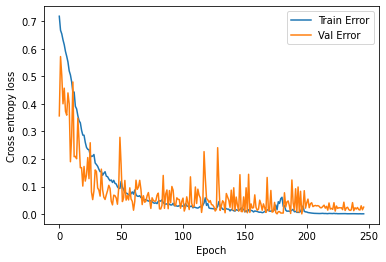

In [49]:
show_final_score(pca_history)

**RAW ANN**

In [50]:
# Model 1 Training on PCA data
raw_model = tf.keras.Sequential()
raw_model.add(layers.Dense(np.asarray(raw_ann_df["data"]).shape[0], activation=tf.nn.relu))
raw_model.add(layers.Dense(32, activation=tf.nn.relu))
raw_model.add(layers.Dense(2, activation=tf.nn.softmax)) 

raw_model.compile(optimizer=keras.optimizers.Adam(),
              loss=tf.keras.metrics.sparse_categorical_crossentropy,
              metrics=['accuracy']
              )

raw_history = raw_model.fit(x=np.stack(raw_ann_df['data'],0),
                    y=np.float32(raw_ann_df["label"]),
                    epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])


...................................................Epoch 00051: early stopping


,loss,accuracy,val_loss,val_accuracy,epoch
50,0.189047,0.93254,0.114449,0.964286,50


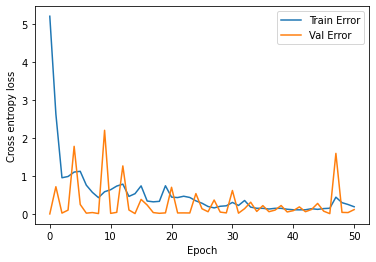

In [51]:
show_final_score(raw_history)

### Validate models on real data
***Raw validation data***

In [52]:
%run helpers.py

In [53]:
# Load raw images
val_cups, val_cup_size = import_images(path='test_samples/cups/')
val_boxes, val_box_size = import_images(path='test_samples/boxes/')

# Alter images to a machine learning friendly format
output_size=128 # 128x128 images
val_flat_cups, val_resized_cups = resize_and_flatten(val_cups, padding=False, max_size=cup_size, output_size=output_size)
val_flat_boxes, val_resized_boxes = resize_and_flatten(val_boxes, padding=False, max_size=box_size, output_size=output_size)

# Reuse same scaler on val data
val_scaled_cups = simple_normalize(val_flat_cups, scaler=raw_scaler)
val_scaled_boxes = simple_normalize(val_flat_boxes, scaler=raw_scaler)

# Reshape (if needed) - row vectors needed for ANN!
val_ann_cups = reshape(val_scaled_cups, vec_type="row")
val_ann_boxes = reshape(val_scaled_boxes, vec_type="row")

# Add to a dataframe for tidyness
val_raw_ann_df = from_numpy_to_pd(data=[val_ann_cups, val_ann_boxes], labels=[0, 1])

***PCA validation data***

In [54]:
# Reuse same PCA
val_pca_cup = simple_pca(val_flat_cups, pca)
val_pca_boxes = simple_pca(val_flat_boxes, pca)

# Get a scaler/normalizer over all the data
# Reuse same scaler on val data
val_scaled_pca_cups = simple_normalize(val_pca_cup, scaler=pca_scaler)
val_scaled_pca_boxes = simple_normalize(val_pca_boxes, scaler=pca_scaler)

# Reshape (if needed) - row vectors needed for ANN!
val_ann_pca_cups = reshape(val_scaled_pca_cups, vec_type="row")
val_ann_pca_boxes = reshape(val_scaled_pca_boxes, vec_type="row")

# Add to a dataframe for tidyness
val_pca_ann_df = from_numpy_to_pd(data=[val_ann_pca_cups, val_ann_pca_boxes], labels=[0, 1])

***Validate***

In [55]:
pca_model.evaluate(x=np.stack(val_pca_ann_df['data'],0),
                    y=np.float32(val_pca_ann_df["label"]));

1/1 [==============================] - 0s 17ms/step - loss: 2.2122 - accuracy: 0.4167


In [56]:
raw_model.evaluate(x=np.stack(val_raw_ann_df['data'],0),
                    y=np.float32(val_raw_ann_df["label"]));

1/1 [==============================] - 0s 16ms/step - loss: 1.1609 - accuracy: 0.5833


***NOTES***
- With 50% and less accuracy on validation, while 100% on test/val data, its obvious that our training data is not very similar to the test data.

***Comparing training data to actual data***

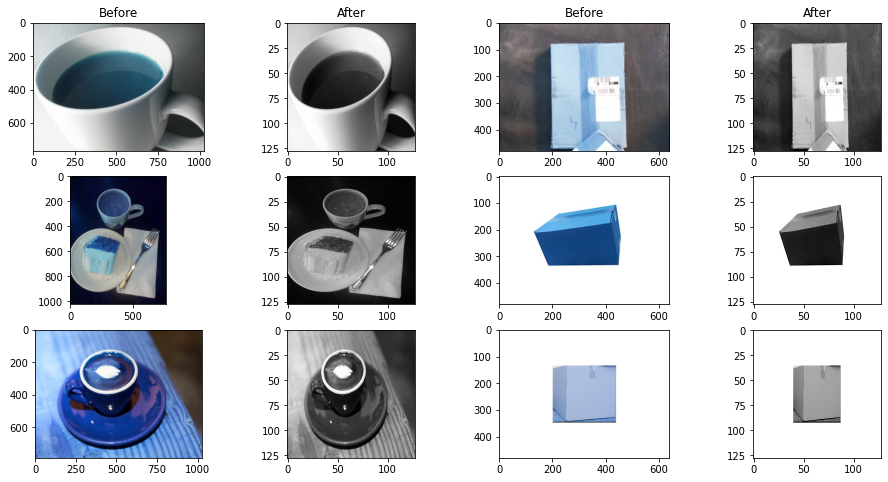

In [57]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(16, 8))
# Cups
axs[0, 0].set_title("Before")
axs[0, 1].set_title("After")
axs[0, 0].imshow(cups[0])
axs[0, 1].imshow(resized_cups[0], cmap="gray")
axs[1, 0].imshow(cups[15])
axs[1, 1].imshow(resized_cups[15], cmap="gray")
axs[2, 0].imshow(cups[29])
axs[2, 1].imshow(resized_cups[29], cmap="gray");
# Boxes
axs[0, 2].set_title("Before")
axs[0, 3].set_title("After")
axs[0, 2].imshow(boxes[0])
axs[0, 3].imshow(resized_boxes[0], cmap="gray")
axs[1, 2].imshow(boxes[15])
axs[1, 3].imshow(resized_boxes[15], cmap="gray")
axs[2, 2].imshow(boxes[-33])
axs[2, 3].imshow(resized_boxes[-33], cmap="gray");


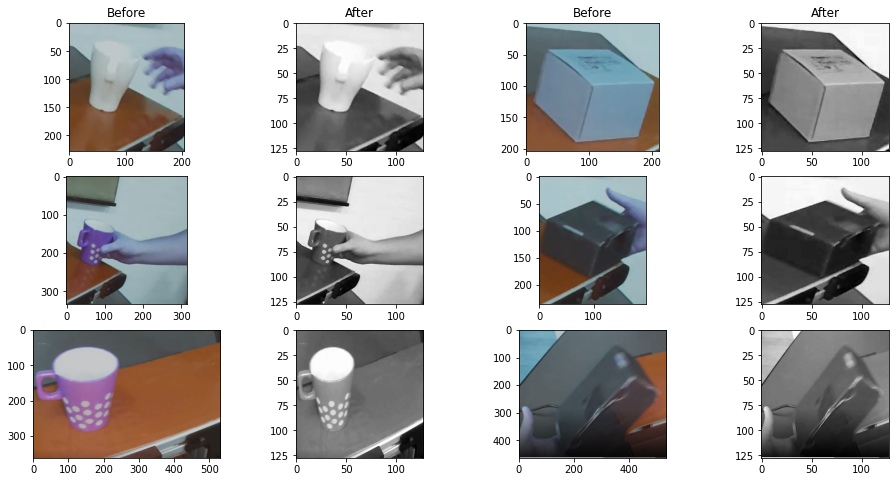

In [59]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(16, 8))
# Cups
axs[0, 0].set_title("Before")
axs[0, 1].set_title("After")
axs[0, 0].imshow(val_cups[0])
axs[0, 1].imshow(val_resized_cups[0], cmap="gray")
axs[1, 0].imshow(val_cups[3])
axs[1, 1].imshow(val_resized_cups[3], cmap="gray")
axs[2, 0].imshow(val_cups[-1])
axs[2, 1].imshow(val_resized_cups[-1], cmap="gray");
# Boxes
axs[0, 2].set_title("Before")
axs[0, 3].set_title("After")
axs[0, 2].imshow(val_boxes[0])
axs[0, 3].imshow(val_resized_boxes[0], cmap="gray")
axs[1, 2].imshow(val_boxes[3])
axs[1, 3].imshow(val_resized_boxes[3], cmap="gray")
axs[2, 2].imshow(val_boxes[-1])
axs[2, 3].imshow(val_resized_boxes[-1], cmap="gray");
